In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100
num_classes = 10

### Generator

입력 처리 부분에서 임베딩과 원소별 곱셈을 사용해 랜덤 잡음 벡터 z와 레이블y를 하나의 표현으로 합침.
1. 레이블 y를 받아 Embedding 층으로 z_dim 크기의 밀집 벡터로 변환
2. Multiply 층으로 레이블 임베딩과 잡음 벡터 z를 합침. 동일한 길이 두 개의 벡터를 각 원소를 곱하여 곱셈 결과로 이루어진 하나의 벡터 출력

이미지를 생성하는 Generator의 입력으로 결과 벡터 주입

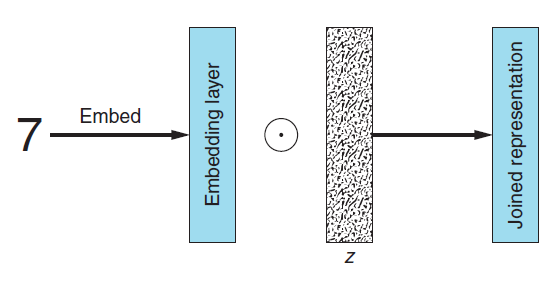

In [3]:
def build_generator(z_dim): 
  model = Sequential()
  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7, 7, 256)))
  model.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding ='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Conv2DTranspose(64, kernel_size = 3, strides = 1, padding ='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Conv2DTranspose(1, kernel_size =3, strides = 2, padding ='same'))
  model.add(Activation('tanh'))
  return model

In [4]:
def build_cgan_generator(z_dim):
  z = Input(shape=(z_dim,))
  label = Input(shape=(1,), dtype = 'int32')

  label_embedding = Embedding(num_classes, z_dim, input_length = 1)(label)
  #label embedding : 레이블을 z_dim 크기의 밀집 벡터로 변환하고 (batch_size, 1, z_dim) 크이의 3D 텐서를 만듦
  label_embedding = Flatten()(label_embedding)
  # 임베딩된 3D 텐서를 펼쳐 (batch_size, z_dim) 크기의 2D 텐서로 바꿈
  joined_representation = Multiply()([z, label_embedding])
  #벡터 z와 레이블 임베딩의 원소별 곱셈
  generator = build_generator(z_dim)

  conditioned_img = generator(joined_representation)

  return Model([z, label], conditioned_img)

### Discriminator

Embedding 층을 사용해 입력 레이블을 밀집 벡터로 변환하고, 3차원 이미지를 입력으로 받음.
1. 레이블을 받아 Embedding 층으로 28x28x1 = 784 크기의 밀집 벡터로 변환
2. 레이블 임베딩을 이미지 차원(28x28x1)로 바꿈
3. 크기를 바꾼 레이블 임베딩을 이에 상응하는 이미지와 연결하여 28x28x2 크기의 표현으로 합침
4. 이미지-레이블 조인트 표현을 CGAN 판별자 네트워크의 입력으로 주입. 새 입력 크기에 맞게 모델의 입력차원 조절

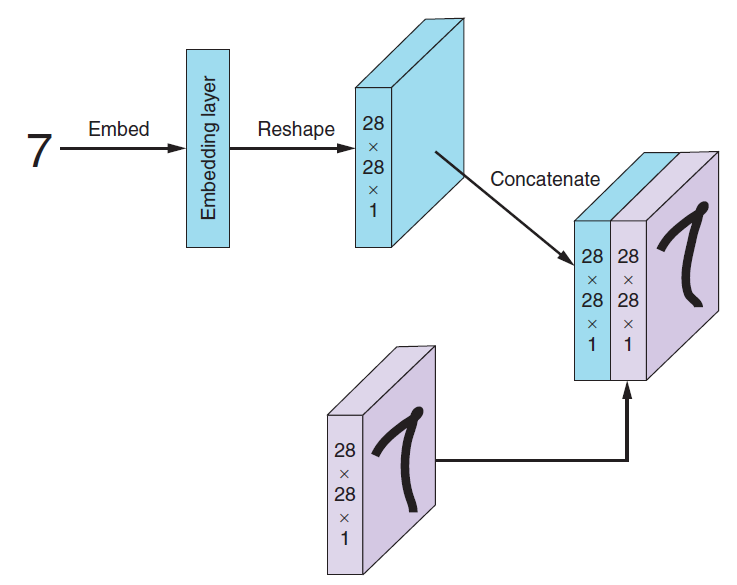

기존 네트워크와의 차이점
1. 모델 입력 차원 조절
2. 첫 번째 합성곱 층의 깊이를 64로 늘림

In [9]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Conv2D(64, kernel_size = 3, strides = 2, padding ='same', input_shape = (img_shape[0], img_shape[1], img_shape[2] + 1)))
  model.add(LeakyReLU(alpha = 0.01))

  model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.01))

  model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.01))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(1, activation = 'sigmoid'))

  return model

In [6]:
def build_cgan_discriminator(img_shape):
  img = Input(shape = img_shape)
  label = Input(shape = (1,), dtype = 'int32')
  label_embedding = Embedding(num_classes, np.prod(img_shape), input_length = 1)(label)
  #label embedding : 레이블을 z_dim 크기의 밀집 벡터로 변환하고 (batch_size, 1, 28x28x1) 크기의 3D 텐서를 만듦
  label_embedding = Flatten()(label_embedding)
  # 임베딩된 3D 텐서를 펼쳐 (batch_size, 28x28x1) 크기의 2D 텐서로 바꿈
  label_embedding = Reshape(img_shape)(label_embedding)
  #레이블 임베딩 크기를 입력 이미지 차원과 동일하게 만듦
  concatenated = Concatenate(axis = -1)([img, label_embedding])
  discriminator = build_discriminator(img_shape)
  classification = discriminator(concatenated)

  return Model([img, label], classification)

### 모델 생성

In [7]:
def build_gan(generator, discriminator):
  z = Input(shape = (z_dim,))
  label = Input(shape = (1,))
  img = generator([z, label])
  classification = discriminator([img, label])
  model = Model([z, label], classification) #생성자 판별자 연결 모델

  return model

In [10]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00001), metrics = ['accuracy'])

generator = build_cgan_generator(z_dim)
discriminator.trainable = False

cgan = build_gan(generator, discriminator)
cgan.compile(loss = 'binary_crossentropy', optimizer = Adam())

1. 판별자 훈련
- 진짜 샘플과 레이블의 랜덤한 미니배치 (x, y)를 받음
- 미니배치에 대한 D((x, y))를 계산하고 이진 분류 손실을 역전파하여 판별자의 파라미터를 업데이트하고 손실을 최소화
- 랜덤 잡음 벡터와 클래스 레이블의 미니배치 (z, y)를 받고 가짜 샘플의 미니배치 G(z, y) = x*|y를 생성
- 미니배치에 대해 D(x*|y,y)를 계산하고 이진 분류 손실을 역전파하여 판별자의 파라미터를 업데이트하고 손실을 최소화
2. 생성자 훈련
- 랜덤 잡음 벡터와 클래스 레이블의 미니배치 (z, y)를 받고 가짜 샘플의 미니배치 G(z, y) = x*|y를 생성
- 미니배치에 대해 D(x*|y,y)를 계산하고 이진 분류 손실을 역전파하여 생성자의 파라미터를 업데이트하고 손실을 최대화

In [11]:
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
  (X_train, y_train), (_, _) = mnist.load_data()
  X_train = X_train / 127.5 - 1.
  X_train = np.expand_dims(X_train, axis = 3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], y_train[idx]

    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict([z, labels])

    d_loss_real = discriminator.train_on_batch([imgs, labels], real)
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, z_dim))
    
    labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    g_loss = cgan.train_on_batch([z, labels], real)

    if (iteration + 1) % sample_interval == 0:
      print('%d [D loss : %f, acc : %.2f%%] [G loss : %f' % (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))

      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      sample_images()

In [12]:
def sample_images(image_grid_rows=2, image_grid_columns=5):

    # 랜덤한 잡음을 샘플링합니다.
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 0–9 사이의 이미지 레이블을 만듭니다.
    labels = np.arange(0, 10).reshape(-1, 1)

    # 랜덤한 잡음에서 이미지를 생성합니다.
    gen_imgs = generator.predict([z, labels])

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드를 설정합니다.
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드를 출력합니다.
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

1000 [D loss : 0.708636, acc : 45.31%] [G loss : 0.635886
2000 [D loss : 0.747744, acc : 20.31%] [G loss : 0.604610
3000 [D loss : 0.701849, acc : 45.31%] [G loss : 0.671580
4000 [D loss : 0.711002, acc : 35.94%] [G loss : 0.653109
5000 [D loss : 0.694872, acc : 51.56%] [G loss : 0.687791
6000 [D loss : 0.693714, acc : 54.69%] [G loss : 0.670402
7000 [D loss : 0.662712, acc : 79.69%] [G loss : 0.712231
8000 [D loss : 0.658643, acc : 75.00%] [G loss : 0.739114
9000 [D loss : 0.690384, acc : 48.44%] [G loss : 0.662018
10000 [D loss : 0.695172, acc : 53.12%] [G loss : 0.677704
11000 [D loss : 0.651056, acc : 68.75%] [G loss : 0.754124
12000 [D loss : 0.682041, acc : 62.50%] [G loss : 0.705966
13000 [D loss : 0.692845, acc : 56.25%] [G loss : 0.731155
14000 [D loss : 0.640944, acc : 76.56%] [G loss : 0.696915
15000 [D loss : 0.677380, acc : 56.25%] [G loss : 0.694732
16000 [D loss : 0.748518, acc : 31.25%] [G loss : 0.628875
17000 [D loss : 0.617783, acc : 75.00%] [G loss : 0.723878
18000 

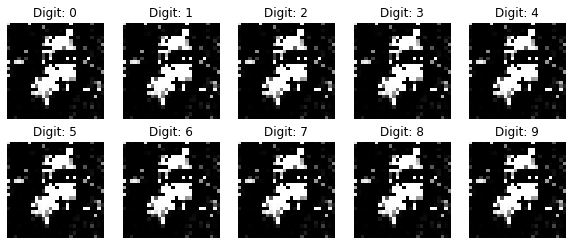

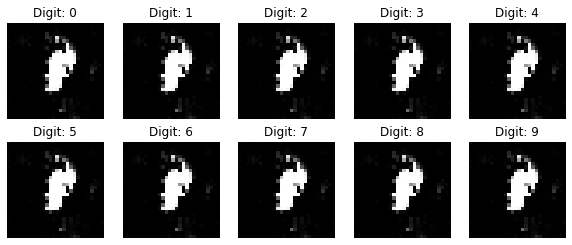

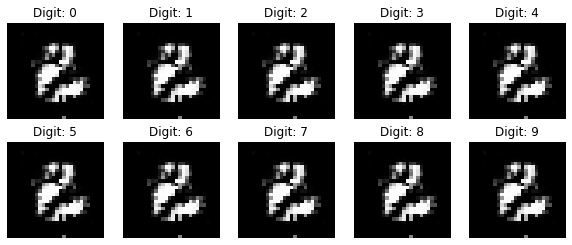

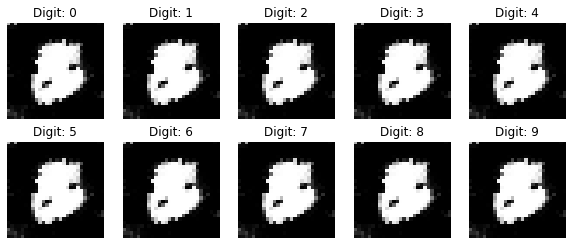

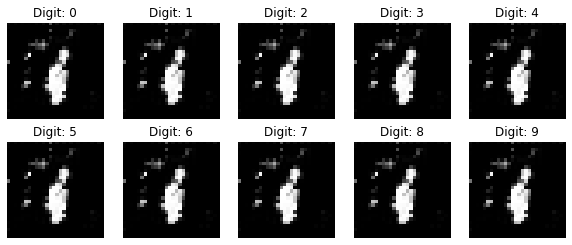

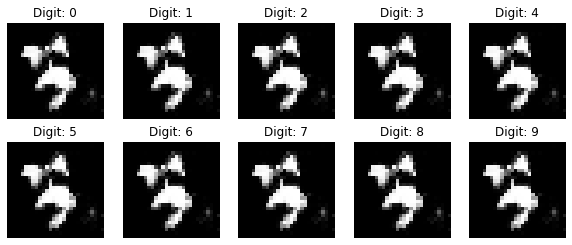

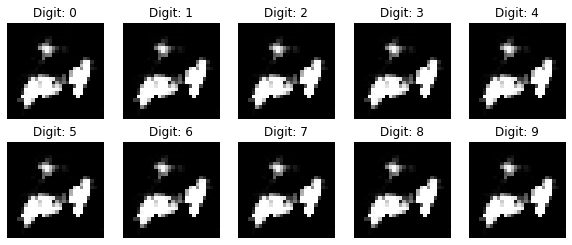

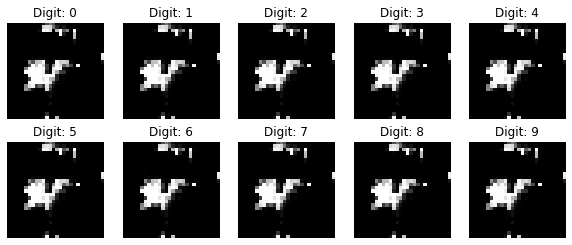

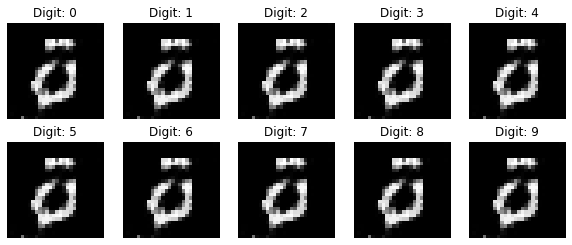

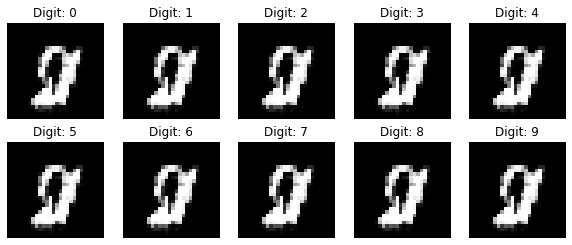

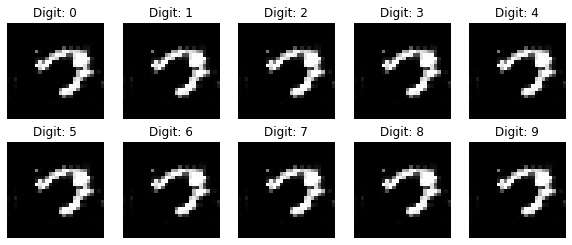

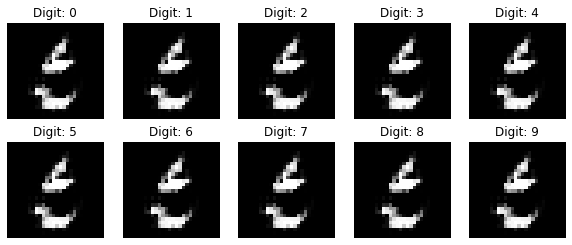

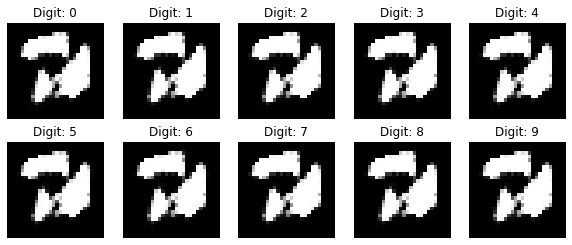

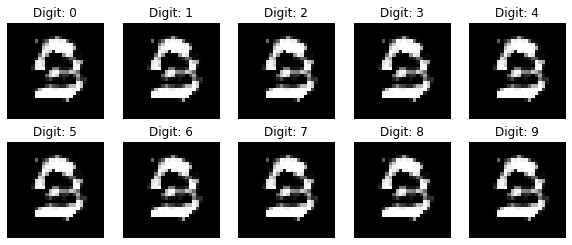

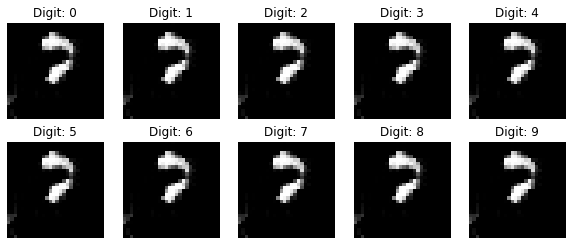

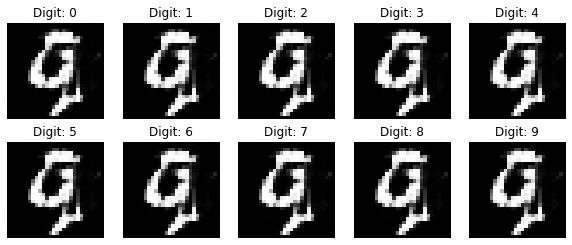

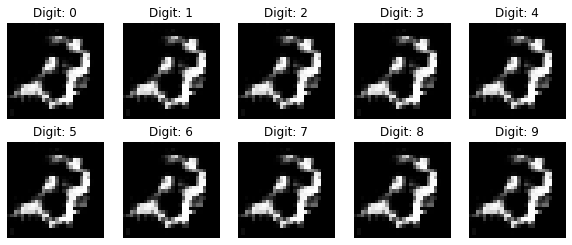

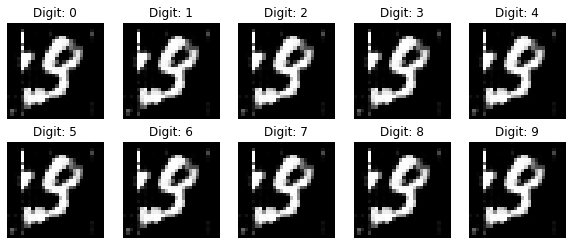

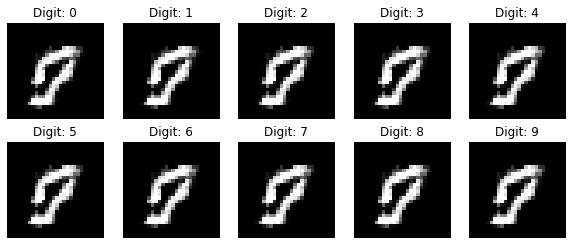

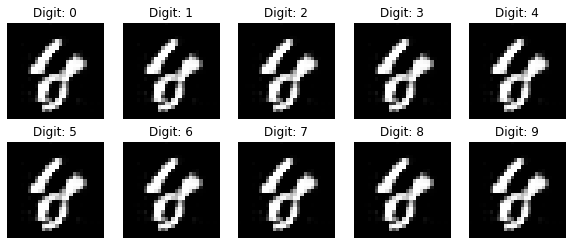

In [13]:
iterations = 20000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)

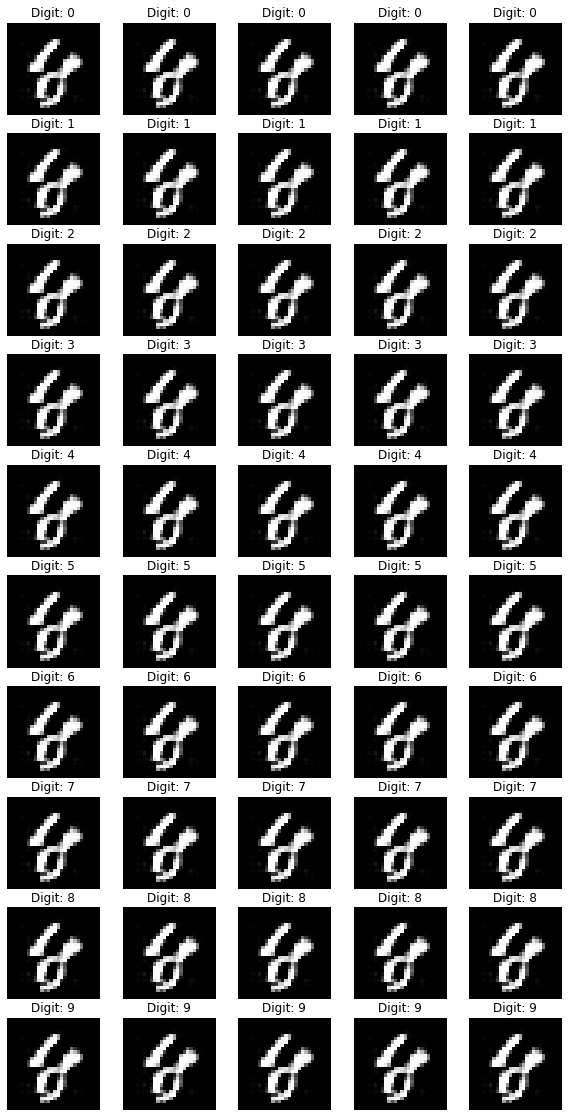

In [14]:
# 그리드 차원을 설정합니다.
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 잡음을 샘플링합니다.
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블을 5개씩 준비합니다.
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# 랜덤한 잡음에서 이미지를 생성합니다.
gen_imgs = generator.predict([z, labels_to_generate])

# 이미지 픽셀 값을 [0, 1] 사이로 스케일을 변환합니다.
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드를 설정합니다.
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # 이미지 그리드를 출력합니다.
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1